In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

import pandas_datareader as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

import datetime as dt
from IPython.display import display, HTML

Using TensorFlow backend.
/Users/rachaeltay/anaconda3/lib/python3.6/site-packages/fix_yahoo_finance/__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and no longer available.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)


In [5]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping

In [6]:
# web scrap from 1/1/2016 to the most recent day for every stock
stockNames = ['AMD', 'SMCI', 'AAPL', 'MSFT', 'IBM', 'HPE', 'GOOG', 'AVGO']

def get_stock(stock, start, end):
    return pdr.get_data_yahoo(stock, start, end)['Close']

stocks = []
#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime(2016, 11, 5))))

## Data Pre-Processing

In [7]:
#size of window
num_lags = 1
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

,AMD_0,AMD_1,SMCI_1,AAPL_1,MSFT_1,IBM_1,HPE_1,GOOG_1,AVGO_1
Date,,,,,,,,,
2016-10-31,-0.353535,-0.292929,0.472073,-0.095720,0.072547,0.061549,-0.117117,0.132324,-0.247450
2016-11-01,-0.525253,-0.353535,0.013007,-0.005447,0.152205,0.302449,0.075075,-0.171854,0.162640
2016-11-02,-0.717172,-0.525253,-0.017598,-0.296498,0.103841,0.040370,-0.339339,0.105691,-0.096081
2016-11-03,-0.444444,-0.717172,0.089518,0.038132,0.032717,0.048314,-0.141140,-0.286235,0.466452
2016-11-04,-0.525253,-0.444444,0.081867,-0.251361,0.075391,0.215090,-0.237237,-0.052426,0.108965


In [10]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#ensure that training_input is a multiple of batch_size
batch_size = 28

# #reshape input of the LSTM to be format [samples, time steps, features]
# training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
# test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
# training_input_1 = training_input
# training_output_1 = training_output
# while (len(training_input_1) % batch_size != 0):
#     training_input_1 = training_input_1[1:]
#     training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training

In [11]:
#define model
model = Sequential()
model.add(Dense(50, input_shape=(len(stocks), )))
model.add(Activation('sigmoid'))
model.add(Dense(70, input_shape=(len(stocks), )))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.03)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input, y=training_output, epochs=500, batch_size=batch_size, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                450       
_________________________________________________________________
activation_3 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 70)                3570      
_________________________________________________________________
activation_4 (Activation)    (None, 70)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 71        
Total params: 4,091
Trainable params: 4,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/

149/149 [==============================] - 0s - loss: 0.0442     
Epoch 91/500
149/149 [==============================] - 0s - loss: 0.0445     
Epoch 92/500
149/149 [==============================] - 0s - loss: 0.0438     
Epoch 93/500
149/149 [==============================] - 0s - loss: 0.0424     
Epoch 94/500
149/149 [==============================] - 0s - loss: 0.0453     
Epoch 95/500
149/149 [==============================] - 0s - loss: 0.0426     
Epoch 96/500
149/149 [==============================] - 0s - loss: 0.0426     
Epoch 97/500
149/149 [==============================] - 0s - loss: 0.0443     
Epoch 98/500
149/149 [==============================] - 0s - loss: 0.0414     
Epoch 99/500
149/149 [==============================] - 0s - loss: 0.0439     
Epoch 100/500
149/149 [==============================] - 0s - loss: 0.0426     
Epoch 101/500
149/149 [==============================] - 0s - loss: 0.0428     
Epoch 102/500
149/149 [==============================] - 0s - l

149/149 [==============================] - 0s - loss: 0.0429     
Epoch 193/500
149/149 [==============================] - 0s - loss: 0.0413     
Epoch 194/500
149/149 [==============================] - 0s - loss: 0.0410     
Epoch 195/500
149/149 [==============================] - 0s - loss: 0.0419     
Epoch 196/500
149/149 [==============================] - 0s - loss: 0.0419     
Epoch 197/500
149/149 [==============================] - 0s - loss: 0.0427     
Epoch 198/500
149/149 [==============================] - 0s - loss: 0.0409     
Epoch 199/500
149/149 [==============================] - 0s - loss: 0.0422     
Epoch 200/500
149/149 [==============================] - 0s - loss: 0.0410     
Epoch 201/500
149/149 [==============================] - 0s - loss: 0.0410     
Epoch 202/500
149/149 [==============================] - 0s - loss: 0.0417     
Epoch 203/500
149/149 [==============================] - 0s - loss: 0.0411     
Epoch 204/500
149/149 [==============================]

149/149 [==============================] - 0s - loss: 0.0370     
Epoch 295/500
149/149 [==============================] - 0s - loss: 0.0359     
Epoch 296/500
149/149 [==============================] - 0s - loss: 0.0348     
Epoch 297/500
149/149 [==============================] - 0s - loss: 0.0342     
Epoch 298/500
149/149 [==============================] - 0s - loss: 0.0337     
Epoch 299/500
149/149 [==============================] - 0s - loss: 0.0345     
Epoch 300/500
149/149 [==============================] - 0s - loss: 0.0310     
Epoch 301/500
149/149 [==============================] - 0s - loss: 0.0319     
Epoch 302/500
149/149 [==============================] - 0s - loss: 0.0393     
Epoch 303/500
149/149 [==============================] - 0s - loss: 0.0335     
Epoch 304/500
149/149 [==============================] - 0s - loss: 0.0307     
Epoch 305/500
149/149 [==============================] - 0s - loss: 0.0372     
Epoch 306/500
149/149 [==============================]

149/149 [==============================] - ETA: 0s - loss: 0.010 - 0s - loss: 0.0342     
Epoch 397/500
149/149 [==============================] - 0s - loss: 0.0210     
Epoch 398/500
149/149 [==============================] - 0s - loss: 0.0212     
Epoch 399/500
149/149 [==============================] - 0s - loss: 0.0198     
Epoch 400/500
149/149 [==============================] - 0s - loss: 0.0195     
Epoch 401/500
149/149 [==============================] - 0s - loss: 0.0224     
Epoch 402/500
149/149 [==============================] - 0s - loss: 0.0195     
Epoch 403/500
149/149 [==============================] - 0s - loss: 0.0227     
Epoch 404/500
149/149 [==============================] - 0s - loss: 0.0204     
Epoch 405/500
149/149 [==============================] - 0s - loss: 0.0209     
Epoch 406/500
149/149 [==============================] - 0s - loss: 0.0278     
Epoch 407/500
149/149 [==============================] - 0s - loss: 0.0197     
Epoch 408/500
149/149 [=======

149/149 [==============================] - 0s - loss: 0.0181     
Epoch 498/500
149/149 [==============================] - 0s - loss: 0.0257     
Epoch 499/500
149/149 [==============================] - 0s - loss: 0.0210     
Epoch 500/500
149/149 [==============================] - 0s - loss: 0.0180     


## Training Outcome

In [12]:
# #predict outcome using only batch size = 1
new_batch_size = 1
# #get weights of trained model
# weights = model.get_weights()
# #build new model and set weights
# new_model = Sequential()
# new_model.add(LSTM(4, batch_input_shape=(new_batch_size, training_input.shape[1], training_input.shape[2]), stateful=True))
# new_model.add(Activation('relu'))
# new_model.add(Dense(1))
# new_model.set_weights(weights)

# adam = optimizers.Adam(lr=0.05)
# new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Training RMSE: %.4f' % rmse)

Training RMSE: 0.1382


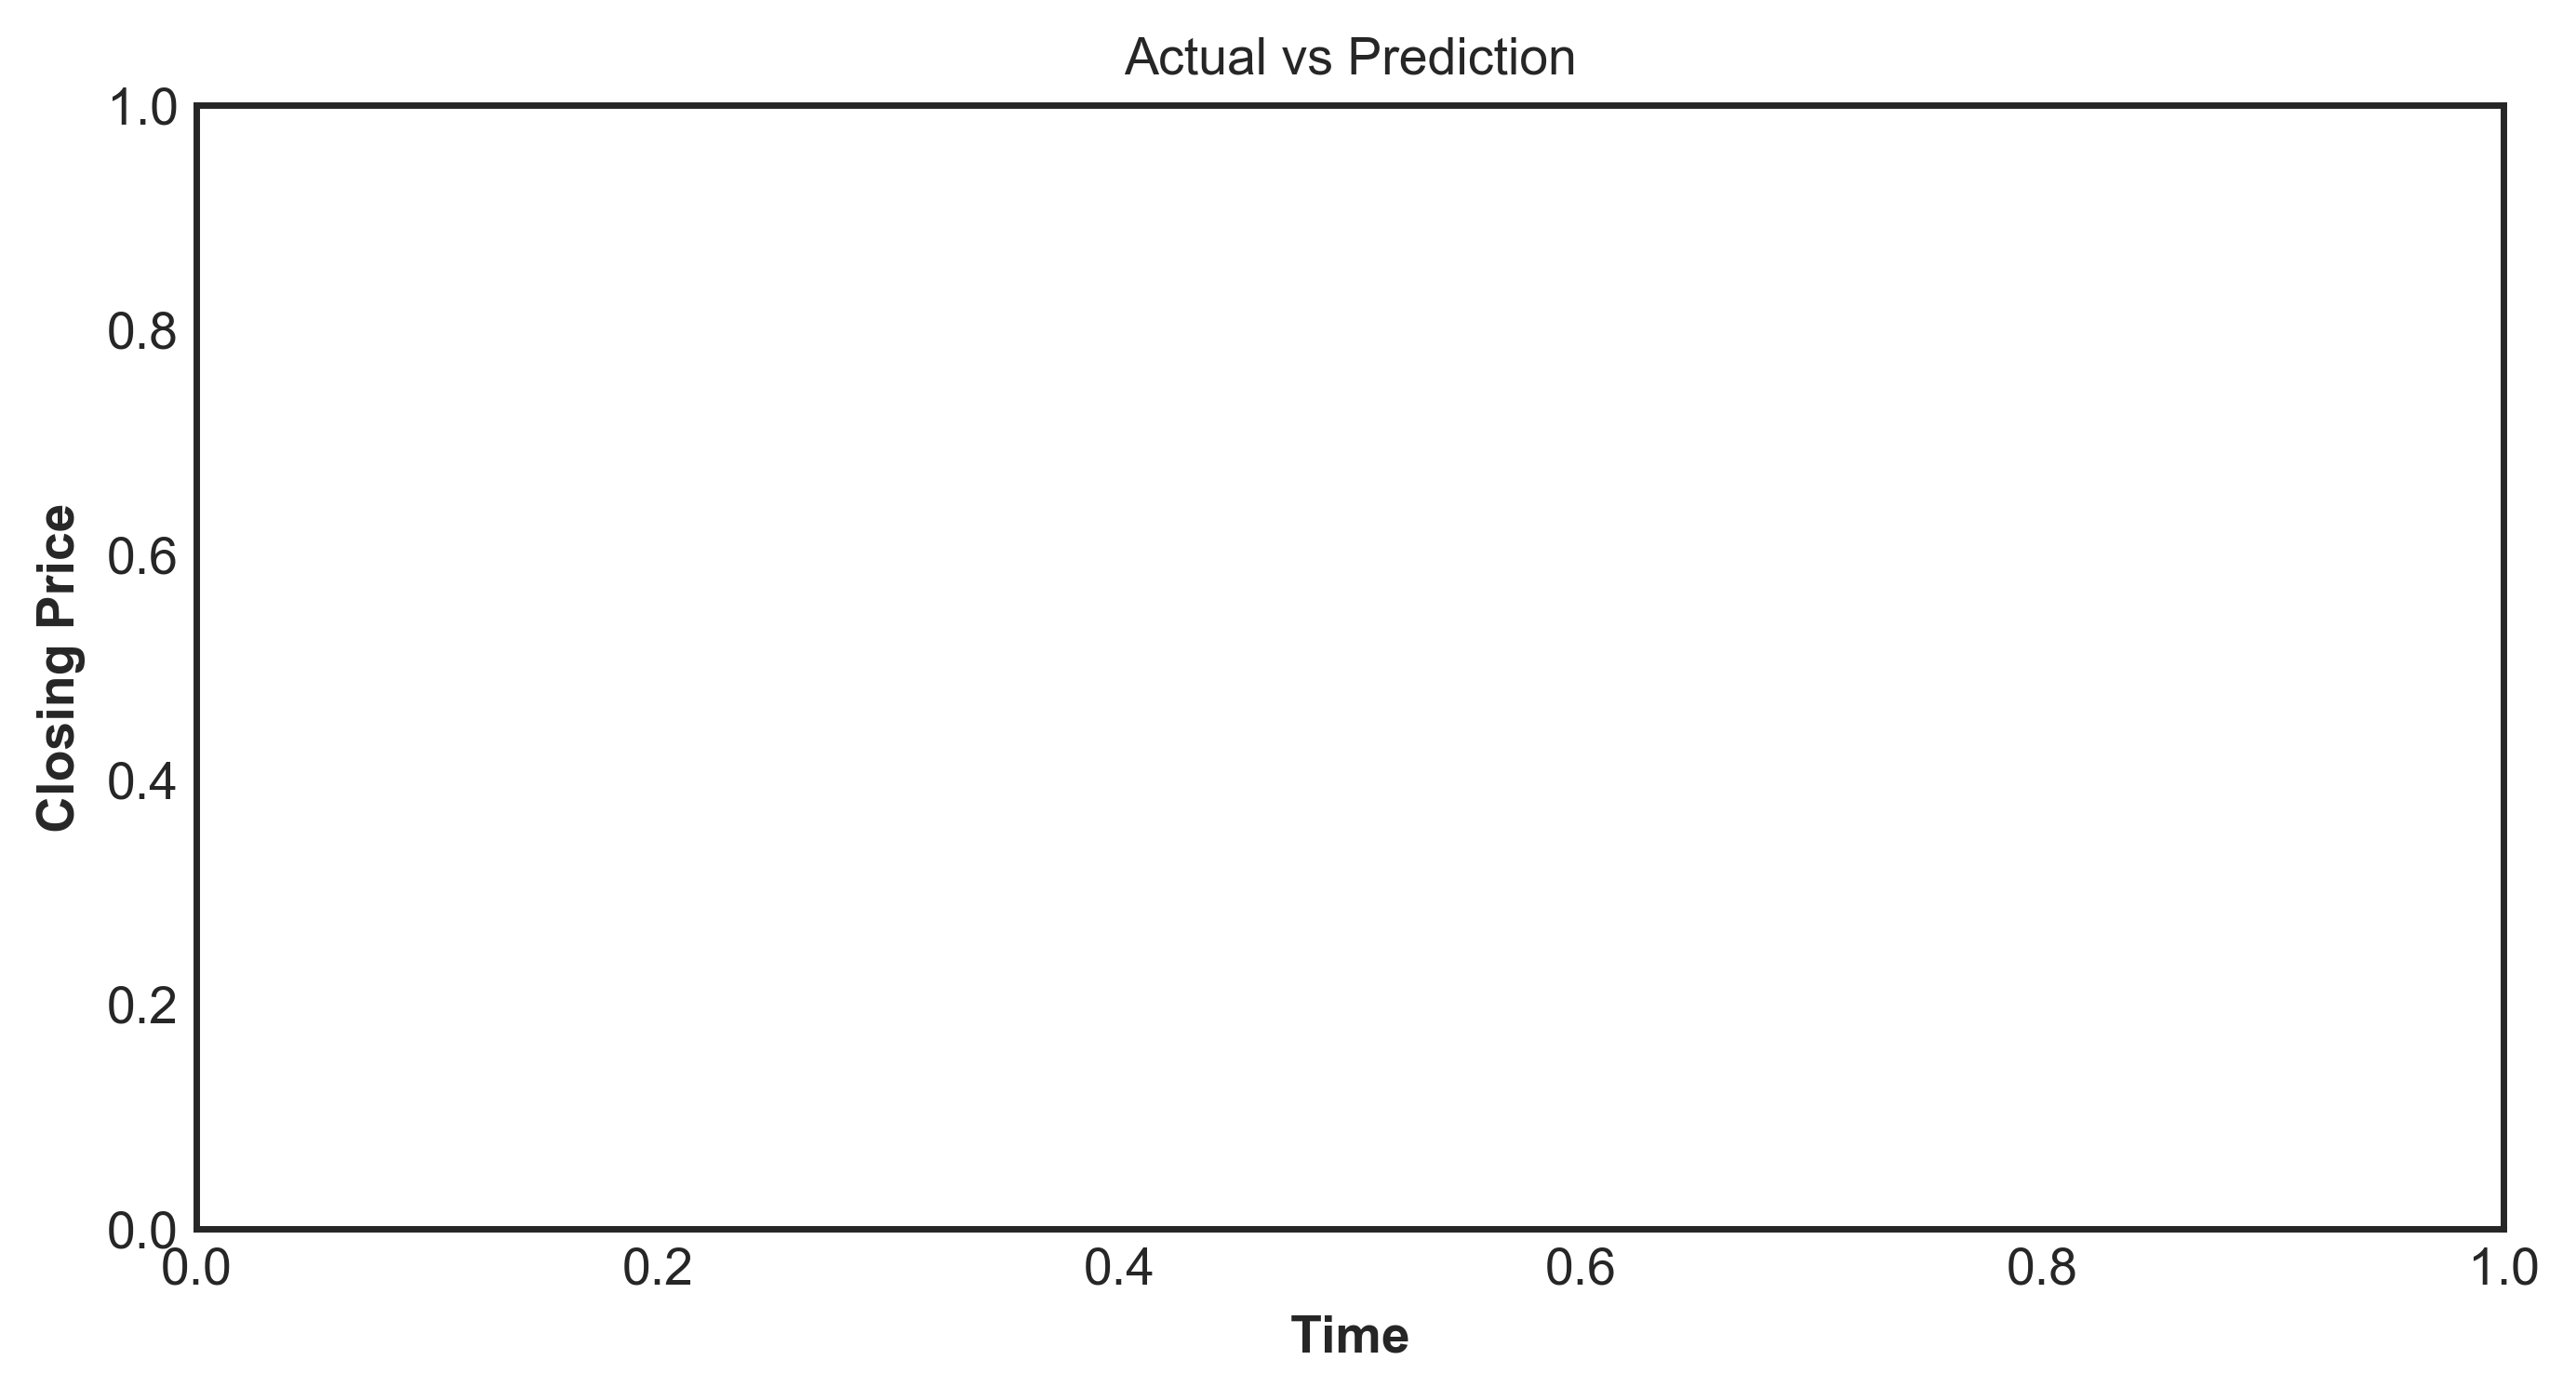

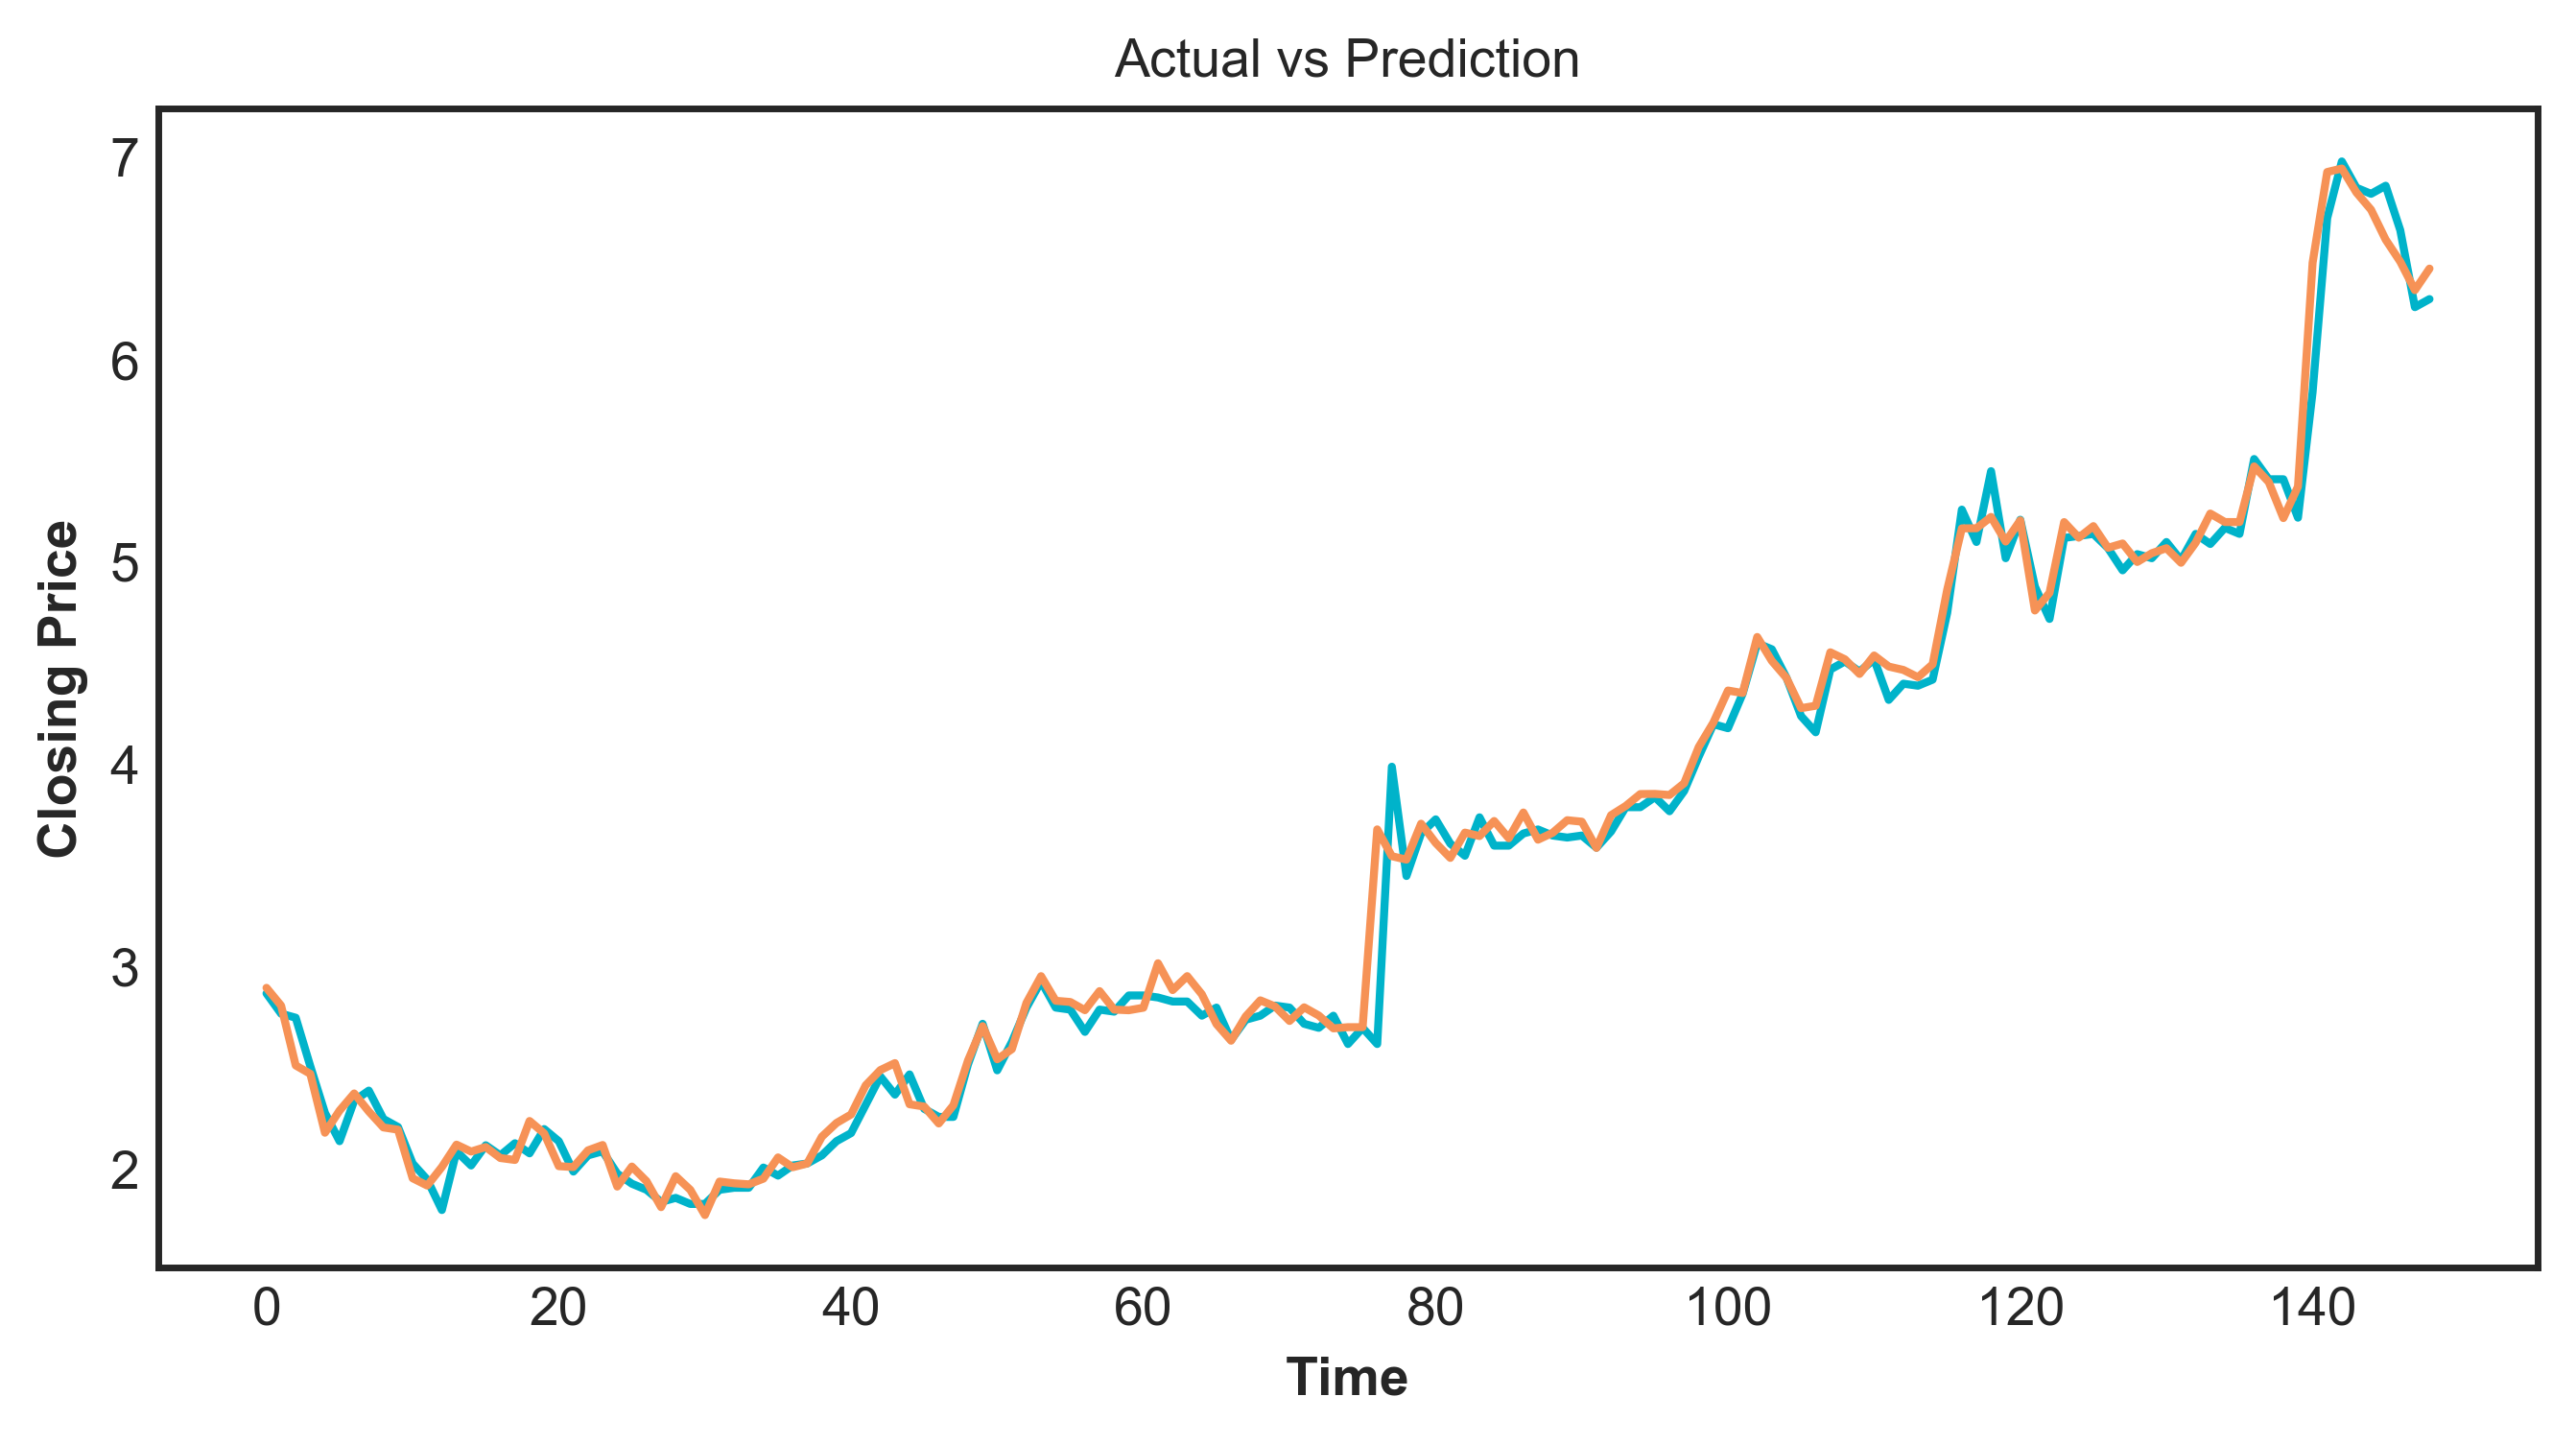

In [13]:
# training_predictions = np.concatenate((np.full((num_lags, 1), training_predictions[0]), training_predictions))
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.5)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction')
plt.plot(stocks[0].iloc[:training_size, :].values, color = "#00b3ca", label='Actual')
plt.plot(training_predictions, color = "#f69256", label='Prediction')
plt.show()

## Test Outcome

In [14]:
test_predictions = model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.2422


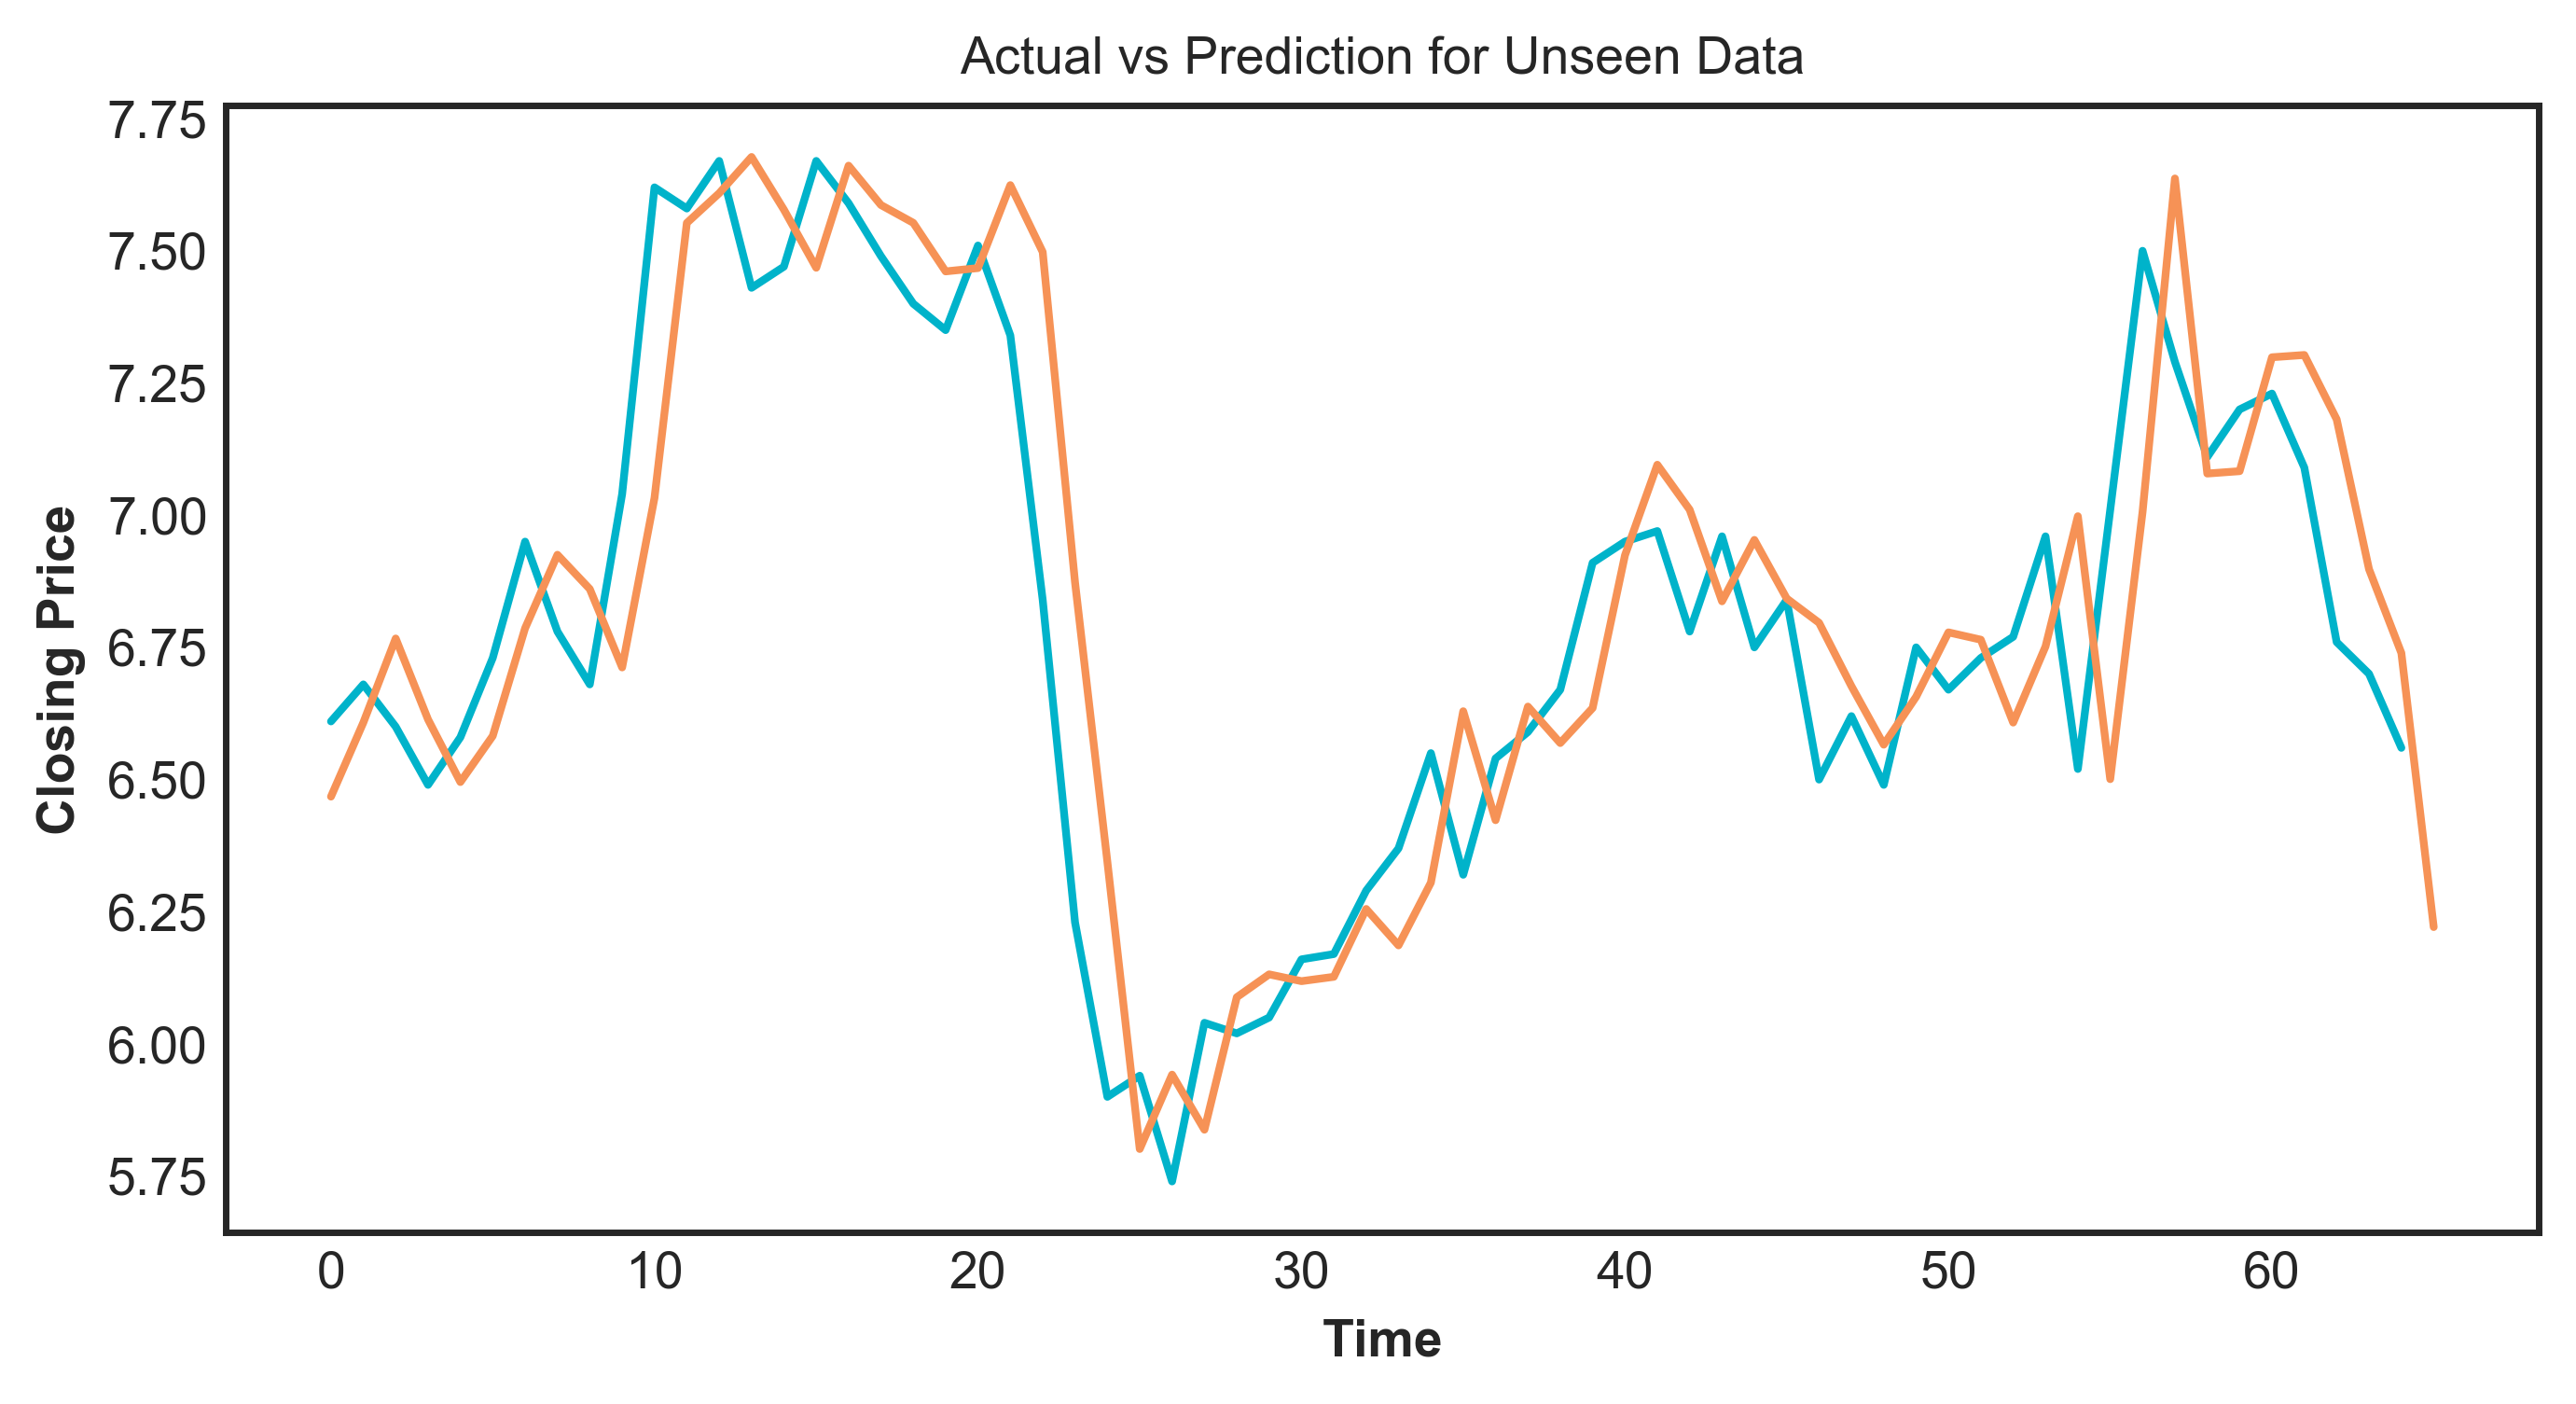

In [15]:
# test_predictions = np.concatenate((np.full((num_lags, 1), test_predictions[0]), test_predictions))
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.5)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.plot(stocks[0].iloc[training_size+1:, :].values, color = "#00b3ca",label='Actual')
plt.plot(test_predictions, color = "#f69256", label='Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction for Unseen Data')
plt.show()

## Forecasted Price

In [16]:
print("Closing Price 3/11/2017")
print(stocks[0].iloc[-1:,:1].values[0][0])
print('\n')
print("Predicted Closing Price on 6/11/2017")
print(test_predictions[-1][0])

Closing Price 3/11/2017
6.56


Predicted Closing Price on 6/11/2017
6.22104
